# Measuring Fluorescence Intensities of Cells

In [1]:
import os
import shutil
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from skimage import exposure
from skimage.filters import threshold_mean as threshold
from skimage.morphology import disk, erosion, dilation
from ipywidgets import interact, fixed, FloatSlider
import mahotas as mh
import imghdr
from tqdm import tqdm
    
# Configure visualizations
%matplotlib inline
pylab.rcParams['figure.subplot.wspace'] = 0.4
pylab.rcParams['figure.subplot.hspace'] = 0.4
pylab.rcParams['figure.figsize'] = 12, 8
pylab.rcParams['axes.titlesize'] = 22
pylab.rcParams['axes.labelsize'] = 20
pylab.rcParams['xtick.labelsize'] = 16
pylab.rcParams['ytick.labelsize'] = 16
pylab.rcParams['legend.fontsize'] = 16
pylab.rc("axes.spines", top=False, right=False)
pylab.rcParams['legend.numpoints'] = 4
sns.set_style('ticks')
palette = ["#1E88E5", "#43A047", "#e53935", "#5E35B1", "#FFB300", "#00ACC1", "#3949AB", "#F4511E"]
sns.set_palette(palette)

## Operations on One Image

In [2]:
def background_region(img):
    img_eq = exposure.equalize_hist(img)
    thresh = threshold(img_eq)
    binary = img_eq > thresh
    gauss = mh.gaussian_filter(binary, 2.)
    g_mean = gauss.mean()
    return gauss < g_mean

In [3]:
def show_processing_steps(images):
    i = 0
    for name, img in images.items():
        plt.figure(i)
        plt.title(name)
        if name == 'Labeled':
            plt.jet()
        else:
            plt.gray()
        plt.imshow(img)
        i += 1

In [4]:
def process_img(img, prior_masks=None, prior_num_cells=None, debug=False):
    
    # Get Background
    background = background_region(img) * img
    bg_val = np.percentile(background[np.nonzero(background)], 25)
    
    # Threshold + smooth edges
    otsu = mh.otsu(img)
    bias = 0.2
    thres = otsu + otsu*bias
    gauss = mh.gaussian_filter(img, 8.0)
    smooth_img = gauss > thres
    labeled, n_objects = mh.label(smooth_img)
    
    # Watershed
    sigma = 18.0
    gauss = mh.gaussian_filter(img.astype(float), sigma)
    maxima = mh.regmax(mh.stretch(gauss))
    maxima,_= mh.label(maxima)
    dist = mh.distance(smooth_img)
    dist = 255 - mh.stretch(dist)
    watershed = mh.cwatershed(dist, maxima)
    watershed *= smooth_img
    
    # Remove cells on the border + objects too small to be cells
    selem = disk(10)
    eroded = erosion(watershed, selem)
    cleaned = mh.labeled.remove_bordering(eroded)
    dilated = dilation(cleaned, selem)
    sizes = mh.labeled.labeled_size(dilated)
    min_size = 3000
    filtered = mh.labeled.remove_regions_where(dilated, sizes < min_size)
    masks, n_objects = mh.labeled.relabel(filtered)
    
    if debug:
        print('Number of Cells: ' + str(n_objects))
        show_processing_steps({'Original': img,
                               'Background': background,
                               'Labeled': labeled,
                               'Watershed': watershed,
                               'Final': masks*img})
        
    if type(prior_masks) is np.ndarray and type(prior_num_cells) is int:
        return (prior_masks, bg_val, prior_num_cells)
    else:
        return (masks, bg_val, n_objects)

In [5]:
def get_regions(img, masks, num_cells):
    regions = []
    for i in range(1, num_cells + 1):
        region = np.divide(masks, i) == 1
        regions.append(region)
    return [img * region for region in regions]

In [6]:
def norm_ave_intensities(regions, bg_val):
    intensities = []
    for reg in regions:
        cell_intensity = np.median(reg[np.nonzero(reg)]) - bg_val
        intensities.append(cell_intensity)
    return intensities

## Test for One Image

In [7]:
img = mh.imread('cas-bs-enz-20171025/dish2/14.001', formatstr='tiff')

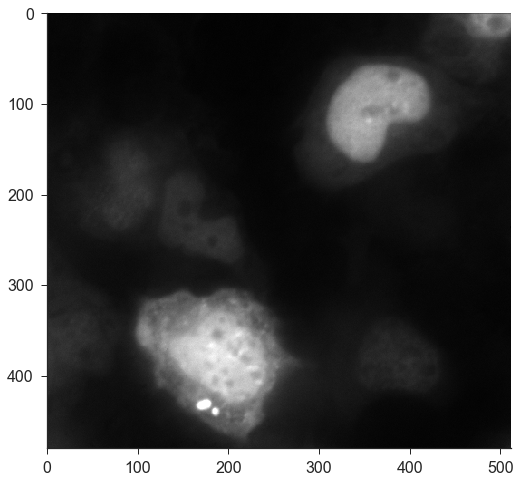

In [8]:
plt.gray()
plt.imshow(img)

Number of Cells: 2


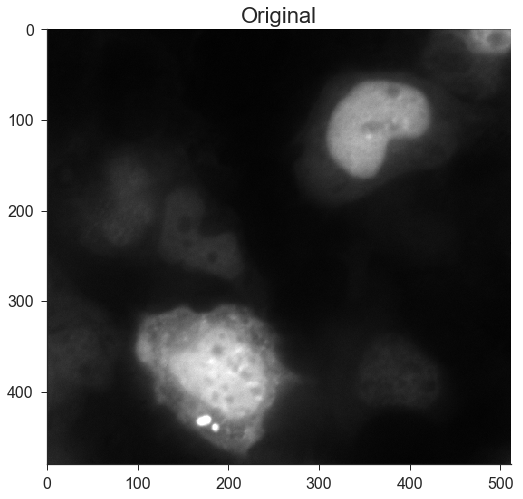

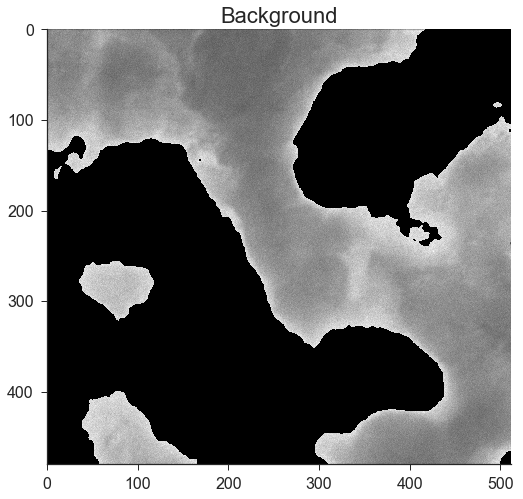

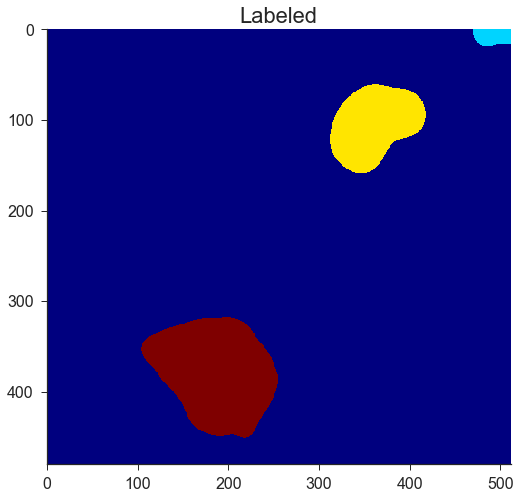

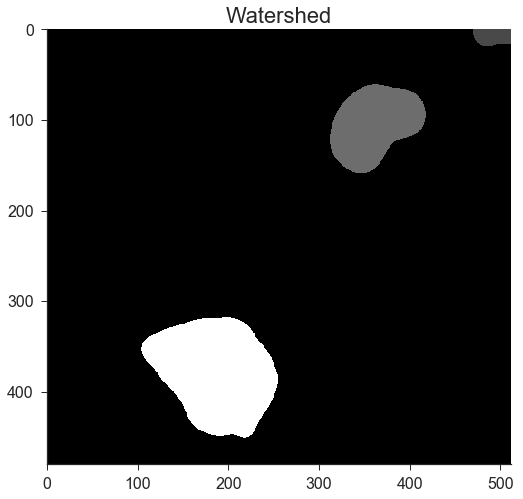

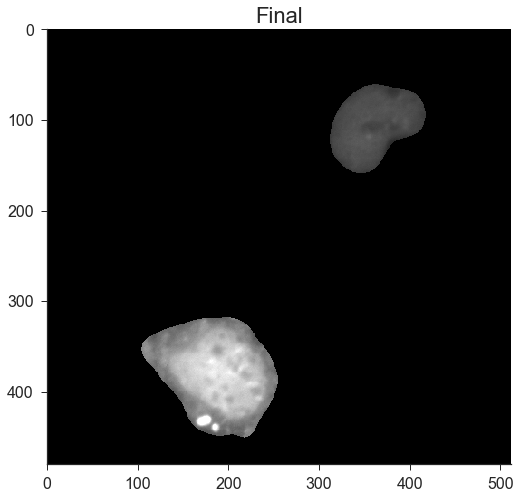

In [9]:
masks, bg_value, num_cells = process_img(img, None, debug=True)

In [10]:
regions = get_regions(img, masks, num_cells)

In [15]:
np.unique(regions[0])

array([    0, 21359, 21871, ..., 52410, 52647, 53087], dtype=uint16)

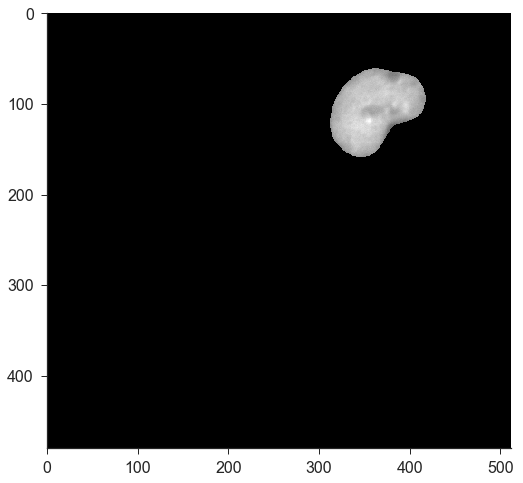

In [12]:
plt.imshow(regions[0])

In [ ]:
intensity_vals = norm_ave_intensities(regions1, bg_value)
intensity_vals

## Run for All Images

In [20]:
def sort_img_files(img_files, priority_channel='11', dont_include=[]):
    sorted_img_files = defaultdict(list)
    for f in img_files:
        sorted_img_files[f.split('.')[1]].append(f)
    sorted_img_files = list(sorted_img_files.values())
    for sublist in sorted_img_files:
        priority_img = [i for i in sublist if i.startswith(priority_channel)][0]
        sublist.insert(0, sublist.pop(sublist.index(priority_img)))
        for d in dont_include:
            for s in sublist:
                if s.startswith(d) and d != priority_channel:
                    sublist.remove(s)
    return sorted_img_files

In [21]:
def run_tasks(root_dir, priority_channels={}, dont_include=['13']):
    img_formats = ['tiff', 'png']
    results = {}
    img_paths = [os.path.join(ROOT_DIR, name) for name in os.listdir(ROOT_DIR)
                 if os.path.isdir(os.path.join(ROOT_DIR, name))]
    for img_path in tqdm(img_paths):
        labeled_img_dir = os.path.join(img_path, 'labeled_images')
        if not os.path.exists(labeled_img_dir):
            os.makedirs(labeled_img_dir)
        else:
            shutil.rmtree(labeled_img_dir)           
            os.makedirs(labeled_img_dir)
        dish = img_path.split('/')[-1]
        try:
            dish_priority_channel = priority_channels[dish]
        except KeyError:
            dish_priority_channel = '11'
        results[img_path] = []
        img_files = [f for f in os.listdir(img_path)
                    if (os.path.isfile(os.path.join(img_path, f))
                    and imghdr.what(os.path.join(img_path, f)))]
        sorted_img_files = sort_img_files(img_files, dish_priority_channel, dont_include)
        for img_group in sorted_img_files:
            masks = None
            num_cells = None
            i = 0
            for img_file in img_group:
                file = os.path.join(img_path, img_file)
                for img_format in img_formats:
                    try:
                        img = mh.imread(file, formatstr=img_format)
                        break
                    except:
                        continue
                masks, bg_value, num_cells = process_img(img, masks, num_cells)
                if i == 0:
                    if num_cells > 0:
                        img_scale = int(np.rint(255 / num_cells)) - 1
                    else:
                        img_scale = 1
                    mh.imsave(os.path.join(labeled_img_dir, img_file) + '.png',
                              img_scale * masks.astype(np.uint8)
                             )
                    i += 1
                regions = get_regions(img, masks, num_cells)
                intensity_vals = norm_ave_intensities(regions, bg_value)
                file_result = {img_file: intensity_vals}
                results[img_path].append(file_result)
    return results

In [22]:
def sort_results_dish(results_dish):
    dish_data = pd.DataFrame(columns=['file', 'cfp', 'yfp', 'gfp', 'mar'])
    for i in range(0, len(results_dish), 4):
        cfp_vals = []
        yfp_vals = []
        gfp_vals = []
        mar_vals = []
        for channel in results_dish[i: i + 4]:
            for k, v in channel.items():
                file = k.split('.')[-1]
                if k.startswith('11'):
                    cfp_vals += v
                if k.startswith('12'):
                    yfp_vals += v
                if k.startswith('14'):
                    gfp_vals += v
                if k.startswith('15'):
                    mar_vals += v
        min_num_cells = min(len(cfp_vals), len(yfp_vals), len(gfp_vals), len(mar_vals))
        files = [file] * min_num_cells
        data = pd.DataFrame.from_dict({
            'file': files,
            'cfp': cfp_vals, 'yfp': yfp_vals,
            'gfp': gfp_vals, 'mar': mar_vals},
            orient='index').transpose()
        dish_data = dish_data.append(data)
        if i == len(results_dish) - 4:
            dish_data['fret_ratio'] = dish_data['yfp'] / dish_data['cfp']
    print(dish_data)
    return dish_data

In [38]:
ROOT_DIR = 'cas-bs-enz-20171031/'

In [39]:
results = run_tasks(ROOT_DIR,
                    {'dish1': '15', 'dish2': '12', 'dish3': '14', 'dish4': '14', 'dish5': '14',
                     'dish6': '15', 'dish7': '12', 'dish8': '14', 'dish9': '14', 'dish10': '14',},
                   )

100%|██████████| 10/10 [06:10<00:00, 38.80s/it]


In [40]:
results

{'cas-bs-enz-20171031/dish1': [{'15.006': [5751.0]},
  {'11.006': [177.0]},
  {'12.006': [98.0]},
  {'14.006': [97.0]},
  {'15.002': []},
  {'11.002': []},
  {'12.002': []},
  {'14.002': []},
  {'15.008': [1999.5]},
  {'11.008': [141.0]},
  {'12.008': [113.0]},
  {'14.008': [63.0]},
  {'15.012': [1622.0]},
  {'14.012': [55.0]},
  {'12.012': [70.0]},
  {'11.012': [129.0]},
  {'15.010': [1337.0]},
  {'12.010': [85.0]},
  {'11.010': [137.0]},
  {'14.010': [54.0]},
  {'15.011': []},
  {'14.011': []},
  {'12.011': []},
  {'11.011': []},
  {'15.007': [1875.0]},
  {'12.007': [98.0]},
  {'11.007': [142.0]},
  {'14.007': [62.0]},
  {'15.009': [2898.0, 2731.0]},
  {'11.009': [141.0, 125.0]},
  {'14.009': [71.0, 64.0]},
  {'12.009': [95.5, 82.0]},
  {'15.001': []},
  {'14.001': []},
  {'12.001': []},
  {'11.001': []},
  {'15.005': []},
  {'14.005': []},
  {'12.005': []},
  {'11.005': []},
  {'15.003': [31508.5]},
  {'12.003': [111.0]},
  {'11.003': [169.0]},
  {'14.003': [320.0]},
  {'15.004': [2

In [41]:
img_paths = [os.path.join(ROOT_DIR, name) for name in os.listdir(ROOT_DIR)
                 if os.path.isdir(os.path.join(ROOT_DIR, name))]
for img_path in img_paths:
    sort_results_dish(results[img_path]).to_csv(img_path + '.csv')

  file     cfp     yfp      gfp   mar fret_ratio
0  006    6795  7888.5     9004   668    1.16093
0  002    2409    6714    10541  1033    2.78705
1  002    5838    7422     9311   714    1.27133
2  002    3900    7312    10195   883    1.87487
0  008    3917  5124.5  10574.5   875    1.30827
1  008    2846  4296.5   8043.5   676    1.50966
0  012    4347    6002     8252   628    1.38072
0  010    4967    6161    12095  1016    1.24039
0  011    2599    4707     6841   670    1.81108
1  011    3502  4986.5     6305   513     1.4239
0  007    6400    8320    16819  1368        1.3
0  009    4380    5651    11254   965    1.29018
0  001  6148.5   10929    18457  1490    1.77751
1  001    5866    9630  14927.5  1189    1.64166
2  001    6541   13079    23395  2085    1.99954
3  001    7772   12970    22199  1799    1.66881
0  005    9986   16822    24760  1962    1.68456
0  003    9123   14734    24776  1994    1.61504
0  004    4445    5026     8765   748    1.13071
1  004    4350    55

### Notes:
- Labeled Images:
    - are labeled in order of shades black to white
    - i.e. cell 1 = dark grey, cell 2 = light grey, cell 3 = white